In [18]:
%pip install pytorch_lightning

In [19]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import numpy as np

In [20]:
import requests

url = "https://www.dropbox.com/scl/fi/24nzzwqm7rkhhjaaugeb9/transformer_data1.csv?rlkey=bo3jf4ee5iuhpjlbf339mp46v&st=6chs9rl7&dl=1"

response = requests.get(url)

# Save the file locally
with open('trans_data.csv', 'wb') as file:
    file.write(response.content)

In [21]:
csv_file_path = "trans_data.csv"  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)

# df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']
df.loc[df['Status'] == 'OOM_CRASH', 'Max GPU Memory (MiB)'] = 45000

print(df['Max GPU Memory (MiB)'])

print("#datapoints: ", len(df))


df = df[['Depth', 'Batch Size', 'Activations-Params', 'Total Activations', 'Total Parameters',
       'Max GPU Memory (MiB)', 'NonDynamicallyQuantizableLinear Count',
       'Linear Count', 'LayerNorm Count', 'Dropout Count']]

print('max layers: ', df['Depth'].max(), 'min: ', df['Depth'].min())
print('max parameters: ', df['Total Parameters'].max(), 'min: ', df['Total Parameters'].min())
print('max activations: ', df['Total Activations'].max(), 'min: ', df['Total Activations'].min())
print('max batch_size: ', df['Batch Size'].max(), 'min: ', df['Batch Size'].min())
print('max gpumemory_max: ', df['Max GPU Memory (MiB)'].max(), 'min: ', df['Max GPU Memory (MiB)'].min())
print('len dataset: ', len(df), df.columns)

0        5217
1        2297
2       13503
3       10249
4       18163
        ...  
5006    11551
5007    45000
5008    12945
5009     6091
5010    10919
Name: Max GPU Memory (MiB), Length: 5011, dtype: int64
#datapoints:  5011
max layers:  314 min:  18
max parameters:  3105662679 min:  7292531
max activations:  377916544 min:  20879
max batch_size:  128 min:  1
max gpumemory_max:  45000 min:  1683
len dataset:  5011 Index(['Depth', 'Batch Size', 'Activations-Params', 'Total Activations',
       'Total Parameters', 'Max GPU Memory (MiB)',
       'NonDynamicallyQuantizableLinear Count', 'Linear Count',
       'LayerNorm Count', 'Dropout Count'],
      dtype='object')


In [22]:
import ast

# 'Depth', 'Batch Size', 'Activations-Params', 'Total Activations', 'Total Parameters',
#        'Max GPU Memory (MiB)', 'NonDynamicallyQuantizableLinear Count',
#        'Linear Count', 'LayerNorm Count', 'Dropout Count'

# Reset the index to ensure it is in the default integer format
df = df.reset_index(drop=True)

max_layer = 0

# Check if the column 'params_activations_list' exists
if 'Activations-Params' in df.columns:
    for i in range(len(df)):
        try:
            # Check if the entry is already a list; if not, use ast.literal_eval to convert it
            entry = df['Activations-Params'].iloc[i]  # Use iloc to access the row by position

            if isinstance(entry, str):
                current_list = ast.literal_eval(entry)
            else:
                current_list = entry

            # Ensure the parsed content is a list
            if isinstance(current_list, list):
                l = len(current_list)
                if l > max_layer:
                    max_layer = l
            else:
                print(f"Unexpected format at index {i}: {entry}")

        except (ValueError, SyntaxError) as e:
            print(f"Error processing entry at index {i}: {entry} - {e}")

    print('Maximum layers:', max_layer)
else:
    print("Column 'params_activations_list' does not exist in the DataFrame.")


Maximum layers: 314


In [23]:
df

,Depth,Batch Size,Activations-Params,Total Activations,Total Parameters,Max GPU Memory (MiB),NonDynamicallyQuantizableLinear Count,Linear Count,LayerNorm Count,Dropout Count
0,66,64,"[('Embedding', 4194304, 70898304), ('NonDynami...",4944960,71749233,5217,8,17,16,24
1,74,8,"[('Embedding', 262144, 34258688), ('NonDynamic...",371536,35277650,2297,9,19,18,27
2,18,32,"[('Embedding', 12582912, 538338816), ('NonDyna...",13108384,545058855,13503,2,5,4,6
3,74,64,"[('Embedding', 4194304, 312577024), ('NonDynam...",7883264,330316780,10249,9,19,18,27
4,42,8,"[('Embedding', 4194304, 785974272), ('NonDynam...",4673064,821066087,18163,5,11,10,15
...,...,...,...,...,...,...,...,...,...,...
5006,242,64,"[('Embedding', 4194304, 122334208), ('NonDynam...",9309568,132997510,11551,30,61,60,90
5007,82,128,"[('Embedding', 134217728, 1732401152), ('NonDy...",163290752,1987947879,45000,10,21,20,30
5008,122,8,"[('Embedding', 1048576, 408578048), ('NonDynam...",2659416,536207983,12945,15,31,30,45
5009,226,128,"[('Embedding', 2097152, 23830656), ('NonDynami...",7814016,27272831,6091,28,57,56,84


In [24]:
# bins = [0, 8000, 16000, 24000, 32000, 40000, 50000]
bins = [0, 10000, 20000, 30000, 40000, 50000]
labels = [i for i in range(0, len(bins) - 1)]
print(bins, labels)
# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['Max GPU Memory (MiB)'], bins=bins, labels=labels, right=False)

# Display some rows where 'memory_usage_label' falls into the last bin (infinite)
inf_rows = df.loc[df['memory_usage_label'] == labels[2]]  # labels[-1] is the label for the last bin
print(inf_rows.head())

[0, 10000, 20000, 30000, 40000, 50000] [0, 1, 2, 3, 4]
    Depth  Batch Size                                 Activations-Params  \
15     74          16  [('Embedding', 4194304, 922179584), ('NonDynam...   
20     82          32  [('Embedding', 4194304, 976119808), ('NonDynam...   
21     98          64  [('Embedding', 16777216, 327135232), ('NonDyna...   
27     90          64  [('Embedding', 16777216, 875688960), ('NonDyna...   
34     90          64  [('Embedding', 33554432, 101335040), ('NonDyna...   

    Total Activations  Total Parameters  Max GPU Memory (MiB)  \
15            6234480        1005619494                 25915   
20            8489536        1061195378                 27459   
21           27619712         437773266                 23351   
27           24103104         935277656                 29347   
34           42625280         188856919                 29329   

    NonDynamicallyQuantizableLinear Count  Linear Count  LayerNorm Count  \
15                   

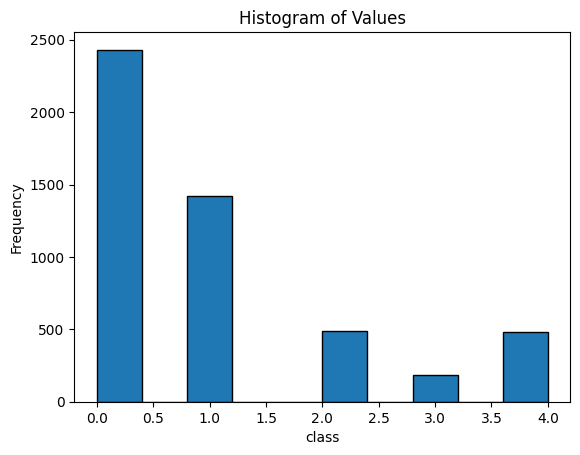

In [25]:
# Plot the histogram
import matplotlib.pyplot as plt

plt.hist(df['memory_usage_label'], bins=len(labels)*2, edgecolor='black')  # bins can be adjusted
plt.title('Histogram of Values')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

In [26]:
# 'Depth', 'Batch Size', 'Activations-Params', 'Total Activations', 'Total Parameters',
#        'Max GPU Memory (MiB)', 'NonDynamicallyQuantizableLinear Count',
#        'Linear Count', 'LayerNorm Count', 'Dropout Count'

print(df.columns)
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['Activations-Params','Depth', 'Batch Size', 'Total Activations', 'Total Parameters',
        'NonDynamicallyQuantizableLinear Count', 'Linear Count', 'LayerNorm Count', 'Dropout Count'
       ]].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

Index(['Depth', 'Batch Size', 'Activations-Params', 'Total Activations',
       'Total Parameters', 'Max GPU Memory (MiB)',
       'NonDynamicallyQuantizableLinear Count', 'Linear Count',
       'LayerNorm Count', 'Dropout Count', 'memory_usage_label'],
      dtype='object')
total data size:  5011
train size 3507, val size: 993, test size: 511


# Dataloader CNN

In [27]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def encode_layer_cnn(layer_type):
    if layer_type == 'Embedding':
        return [0, 0, 0]
    elif layer_type == 'NonDynamicallyQuantizableLinear':
        return [0, 0, 1]
    elif layer_type == 'LayerNorm':
        return [0, 1, 0]
    elif layer_type == 'Dropout':
        return [0, 1, 1]
    elif layer_type == 'Linear':
        return [1, 0, 0]
    else:
        print(layer_type)
        raise ValueError("Unknown layer type")

# Function to process each sequence
def process_sequence(sequence):
    # print(sequence)
    processed_sequence = []
    for entry in eval(sequence):  # Evaluate string as list of tuples
        layer_type, feature_1, feature_2 = entry
        # for fc
        # encoded_layer = encode_layer(layer_type)
        # for cnn
        encoded_layer = encode_layer_cnn(layer_type)
        combined = encoded_layer + [feature_1, feature_2]
        processed_sequence.append(combined)
    return np.array(processed_sequence)

def get_filtered_lists(list1, list2, list3):
    filtered_list1, filtered_list2, filtered_list3 = zip(*[(l1, l2, l3) for l1, l2, l3 in zip(list1, list2, list3) if len(l1) > 0])
    return filtered_list1, filtered_list2, filtered_list3

# Dataset preparation
class LayerSequenceDataset(Dataset):
    def __init__(self, x_data, y_labels, max_seq_len):
        self.x_data = [process_sequence(seq[0]) for seq in x_data]
        self.batch_size = [np.array(seq[1:]).astype(np.int64) for seq in x_data]
        self.y_labels = y_labels
        self.x_data, self.batch_size, self.y_labels = get_filtered_lists(self.x_data, self.batch_size, self.y_labels)
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        sequence = self.x_data[idx]
        batch_size = self.batch_size[idx]
        label = self.y_labels[idx]
        # Padding sequences to max length
        if len(sequence) < self.max_seq_len:
            padded_sequence = np.pad(sequence, ((0, self.max_seq_len - len(sequence)), (0,0)), 'constant')
        else:
            padded_sequence = sequence[:self.max_seq_len]


        return torch.tensor(padded_sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(batch_size, dtype=torch.float32)



# Example Usage
max_seq_len = max_layer  # Set the max sequence length based on your data
x_train = np.array(x_train)  # Your input sequences here
y_train = np.array(y_train)  # Your labels here

# Initialize dataset and dataloader
train_dataset = LayerSequenceDataset(x_train, y_train, max_seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = LayerSequenceDataset(x_val, y_val, max_seq_len)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = LayerSequenceDataset(x_test, y_test, max_seq_len)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

inputs, label_sample, batch_sample = next(iter(train_dataloader))
print(inputs.shape, label_sample.shape, batch_sample.shape)


torch.Size([128, 314, 5]) torch.Size([128]) torch.Size([128, 8])


# model

In [28]:
from pytorch_lightning import seed_everything

seed = 11  # Set your desired seed
seed_everything(seed, workers=True)
torch.use_deterministic_algorithms(False)


INFO:lightning_fabric.utilities.seed:Seed set to 11


In [29]:
import torch.optim as optim

class TransformerClassifier(nn.Module):
    def __init__(self, num_features, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout, max_seq_len):
        super(TransformerClassifier, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Sequential(nn.Linear(num_features, d_model),  # Embedding layer for input features
                                        # nn.LayerNorm(d_model),
                                       nn.BatchNorm1d(max_seq_len),
                                       nn.ReLU(),
                                       nn.Linear(d_model, d_model),
                                       nn.BatchNorm1d(max_seq_len),
                                       nn.ReLU(),
                                       )
        # Positional Encoding
        self.positional_encoding = nn.Parameter(self._get_positional_encoding(max_seq_len, d_model), requires_grad=False)

        # Transformer layers
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)

        # Final classification layer
        self.fc_out = nn.Sequential(nn.Linear(d_model+8, d_model),
                                    nn.BatchNorm1d(d_model),
                                    nn.ReLU(),
                                    nn.Linear(d_model, num_classes),
        )

    def _get_positional_encoding(self, max_seq_len, d_model):
        pos_encoding = torch.zeros(max_seq_len, d_model)
        positions = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        pos_encoding[:, 0::2] = torch.sin(positions * div_term)
        pos_encoding[:, 1::2] = torch.cos(positions * div_term)

        return pos_encoding.unsqueeze(0)

    def forward(self, x, batch_size_feature):
        # Add positional encoding
        seq_len = x.size(1)
        x = self.embedding(x) + self.positional_encoding[:, :seq_len, :]

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Classification (average pooling over sequence dimension)
        x = x.sum(dim=1)  # Pool over the sequence dimension

        # Ensure batch_size_feature has the correct shape
        batch_size_feature = batch_size_feature.unsqueeze(1) if batch_size_feature.dim() == 1 else batch_size_feature

        # batch_size_feature=batch_size_feature.unsqueeze(1)
        x = torch.cat((x, batch_size_feature), dim=1)

        # Output layer for classification
        output = self.fc_out(x)

        return output

In [30]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = TransformerClassifier(num_features=5, num_classes=len(labels), d_model=6, nhead=3,
                                           num_layers=3, dim_feedforward=8, dropout=0, max_seq_len=max_layer)
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x, b):
        return self.model(x, b)

    def training_step(self, batch, batch_idx):
        x, y, b = batch[0], batch[1], batch[2]
        y = y.long()
        logits = self.forward(x, b)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, b = batch[0], batch[1], batch[2]
        y = y.long()
        logits = self.forward(x, b)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = optim.AdamW(self.parameters(), lr=0.001)

        return optimizer

    # def configure_optimizers(self):
    #     optimizer = Adam(self.parameters(), lr=0.001)

    #     # Use a scheduler that doesn't require setting the learning rate explicitly
    #     scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    #     return {
    #         'optimizer': optimizer,
    #         'lr_scheduler': {
    #             'scheduler': scheduler,
    #             'monitor': 'val_loss',
    #             'frequency': 1
    #         }
    #     }

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')
classifier_model = classification_gpu_usage(output_size = len(labels))
classifier_model.train()



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


classification_gpu_usage(
  (model): TransformerClassifier(
    (embedding): Sequential(
      (0): Linear(in_features=5, out_features=6, bias=True)
      (1): BatchNorm1d(314, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=6, out_features=6, bias=True)
      (4): BatchNorm1d(314, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
          )
          (linear1): Linear(in_features=6, out_features=8, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=8, out_features=6, bias=True)
          (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((6,)

In [32]:
trainer = pl.Trainer(
    max_epochs=600,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | model     | TransformerClassifier | 4.3 K  | train
1 | criterion | CrossEntropyLoss      | 0      | train
------------------------------------------------------------
2.4 K     Trainable params
1.9 K     Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.534


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 1.466


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 1.362


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 1.295


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.209


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.145


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.075


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.036


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.994


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.949


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.915


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.888


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.868


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.833


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.804


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.784


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.749


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.729


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.718


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.715


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.687


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.683


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.658


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.647


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.638


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.628


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.619


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.617


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.606


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.592


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.592


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.572


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.569


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.564


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.559


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.545


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.542


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.540


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.540


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.534


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.524


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.520


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.510


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.504


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.493


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.491


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.486


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.483


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.481


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.475


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.474


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.473


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.459


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.455


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.454


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.446


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.443


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.440


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.430


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.427


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.417


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.416


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.412


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.408


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.407


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.400


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.398


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.396


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.394


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.392


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.388


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.383


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.381


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.380


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.378


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.375


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.373


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.371


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.368


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.367


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.366


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.363


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 20 records. Best score: 0.363. Signaling Trainer to stop.


In [33]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0],test_data[2])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.8708
Precision: 0.8432
Recall: 0.8708
F1-Score: 0.8562

Confusion Matrix:
[[235   7   0   0   0]
 [ 17 122   4   0   0]
 [  1  17  40   0   2]
 [  0   2   7   0   6]
 [  0   1   2   0  48]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       242
           1       0.82      0.85      0.84       143
           2       0.75      0.67      0.71        60
           3       0.00      0.00      0.00        15
           4       0.86      0.94      0.90        51

    accuracy                           0.87       511
   macro avg       0.67      0.69      0.68       511
weighted avg       0.84      0.87      0.86       511



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m